# **LESSON 6** **Transfer Learning**: 
: Taking a model and applying it with a couple of additional tweaks to new 
scenario


*   Large dataset에서 trained 된 neural network가 한번도 적용되지 못했던 dataset의 처리에 사용될 수 있다.
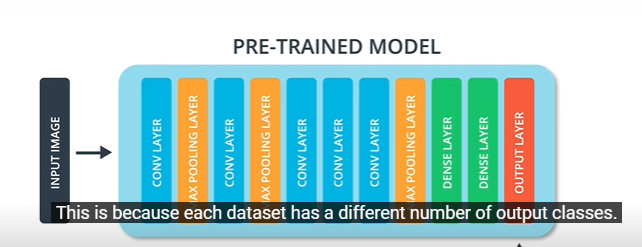
*   Output classes의 값이 다르기 때문에 그거만 바꿔서 적용해주면 된다.





*   **Freezing the model (FROZEN)**
  - 원래의 network에서 pre-trained 모델 부분은 변하지 않게 내버려둬야하는데, 마지막 output만 train을 받을 variable로 변환시키는 작업이다. 다른 pre-trained model의 layer들은 똑같이 유지.--> 이러니까 전체를 학습시키지 않아도 되어서 **시간도 절약**된다.
  - 앞에 layer들도 바뀌어 버리면 training도중 공부하는 feature들이 달라지므로 안된다. (New classification layer이 untrained기 때문.)
*   TensorFlow Hub
  - 이미 pre-trained 된 모델들을 모아둔 library! transfer learning 필요시에 꺼내쓸 수 있음
  - Classifier URL을 Tf hub에서 가져오는 것으로 다운로드는 충분.



# Download the classifier

In [ ]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

single hub Keras layer다. 

# Run it on a single layer

73728/61306 [====================================] - 0s 0us/step


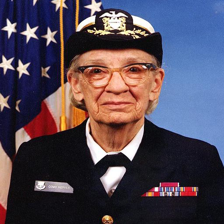

In [ ]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper 

- Imagenet에 없는 사진을 다운받아서 확인
- Imagenet의 RES에 맞게 resize 해줌.

In [ ]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

- **array** : 배열을 통해서 적은 메모리로 많은 데이터를 빠르게 처리할 때 사용하는 함수.
- np.array는 type을 확인하면 리스트 배열이 아니라 객체 배열임. 각 자료형이 모두 같아야 함 --> 처리속도는 빠른편!

In [ ]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [ ]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653



*   logit vector 값이 나왔는데, 이거는 이미지에 대한 각 class 확률 판별에 쓰인다. 한마디로 [0,1] 맵핑 시켜주는 것.
- **Tf에서 logit** 이란? : classification model의 non-normalized 된 raw한 것이 normalized되게 하는데, 이번 레슨 문제처럼 multi-classification problem에서 나온 vector값이 softmax function으로 들어가서 probability 계산에 쓰이는 것이라 한다.
*   **argmax** : array의 함수 중 최대값 index를 반환하는 함수. 반대는 argmin.
이 argmax를 axis에 관해서도 둘 수 있는데, 이게 이번 레슨에서 쓰인 거다. axis를 쭉 훑으면서 가장 큰값(max니까) 을 도출한다. 
- axis =0 은 행, axis =1 은 열
- axis =-1은 역순이다. **(엥? 왜 썼어요?)**
- 지금은 653 class가 뭘 의미하는 지 모르는데, 이걸 human readable하게 바꾼것이.. 밑. 653 class가 무엇을 의미하는 지를 알아내려고 밑에서 library를 부른것.



# Decode the predictions

24576/10484 [======================================================================] - 0s 0us/step


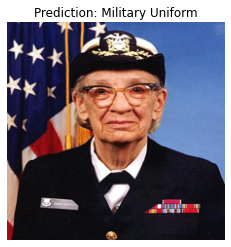

In [ ]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())



*   파읽을 읽어오기 위한 method
  - read() : 파일 전체의 내용을 하나의 문자열로 읽어옴
  - splitlines() : 여러 라인으로 구분되어 있는 문자열을 한 라인씩 분리해서 리스트로 변환



# Part 2: Use a TensorFlow Hub models for the Cats vs. Dogs dataset

In [ ]:
for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (262, 350, 3)
Image 2 shape: (409, 336, 3)
Image 3 shape: (493, 500, 3)




*   **image.shape** : 이미지의 차원크기를 출력하게 하는 함수임.RGB 등등 형식에 맞게 출력됨
*   dataset을 Mobilenet에 맞게 reformat하는 과정
-* shuffle-buffer only has to cold-start once.* 가 뭔뜻인지 모르겠음

In [ ]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)



* **prefetch는 어떤 친구**? 속도를 빠르게 해주는 데이터 처리과정같은데 이해가 잘 안감.- 그냥 optimization의 일종이라고 한다.



## Run the classifier on a batch of images

In [ ]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['golden retriever', 'tabby', 'German shepherd',
       'miniature pinscher', 'schipperke', 'Siamese cat',
       'American Staffordshire terrier', 'German short-haired pointer',
       'tiger cat', 'Rottweiler', 'Egyptian cat', 'tiger cat', 'tabby',
       'Chesapeake Bay retriever', 'tabby', 'Tibetan mastiff',
       'Egyptian cat', 'Rottweiler', 'flat-coated retriever', 'Leonberg',
       'Labrador retriever', 'golden retriever', 'English springer',
       'tiger cat', 'wire-haired fox terrier', 'tabby', 'tabby',
       'Egyptian cat', 'miniature poodle', 'whippet', 'tabby', 'pug'],
      dtype='<U30')



*   **iter** (iterator) : 반복자 지정함수
*   Dataset 관련 함수정리
  - repeat() : dataset 반복
  - batch () : data batch size
  - **take ()** : dataset을 몇번 불러올 건지


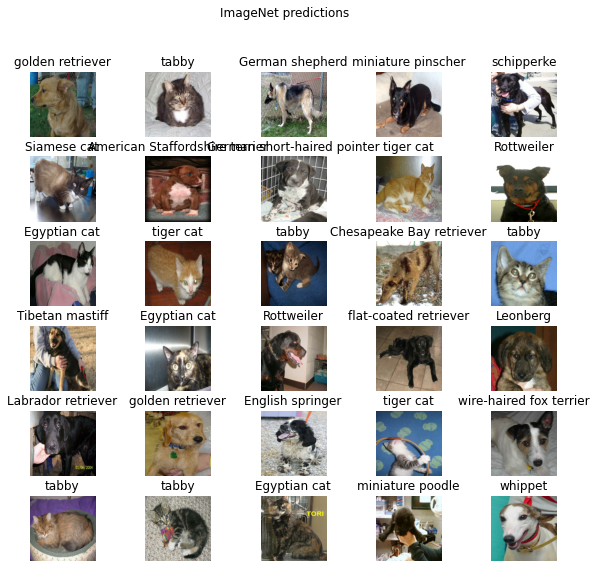

In [ ]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")



*   subplot 함수는 저번시간에도 헷갈렸지만, 원래는 여러 개의 그래프를 한 그림에 나타나게 할 수 있는 함수로, **subplot(nrwos, ncole, index)** 순이 맞다고 한다.



# Part 3: Do simple transfer learning with TensorFlow Hub
- **feature_extractor**: partial model from TensorFlow Hub (without the final classification layer). The reasoning for this term is that it will take the input all the way to a layer containing a number of features.

In [ ]:
feature_extractor.trainable = False

코어 개념인 한 줄 인 거 같다. 마지막 classification row는 untrainable하게 만드는 것

## Train the model

We now train this model like any other, by first calling `compile` followed by `fit`.

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
582/582 [==============================] - 66s 98ms/step - loss: 0.0535 - accuracy: 0.9822 - val_loss: 0.0313 - val_accuracy: 0.9895
Epoch 2/6
582/582 [==============================] - 61s 96ms/step - loss: 0.0300 - accuracy: 0.9897 - val_loss: 0.0352 - val_accuracy: 0.9880
Epoch 3/6
582/582 [==============================] - 60s 95ms/step - loss: 0.0256 - accuracy: 0.9909 - val_loss: 0.0299 - val_accuracy: 0.9901
Epoch 4/6
582/582 [==============================] - 60s 95ms/step - loss: 0.0221 - accuracy: 0.9929 - val_loss: 0.0308 - val_accuracy: 0.9905
Epoch 5/6
582/582 [==============================] - 61s 96ms/step - loss: 0.0197 - accuracy: 0.9931 - val_loss: 0.0333 - val_accuracy: 0.9893
Epoch 6/6
582/582 [==============================] - 60s 96ms/step - loss: 0.0174 - accuracy: 0.9945 - val_loss: 0.0321 - val_accuracy: 0.9903


- 궁금해서.. exercise할 때 epoch설정은 우리가 직접 해야할텐데 얼마정도가 적절한 지 어떻게 알고 하지..? 그래프 plt 된거 보면, epoch 3 이후부터는 거의 validation accuracy 값 변화가 없는데 이 감을 어떻게 잡아야할까..
- 그리고 여기 가져오지 않았지만 아래 코드의 **plt.legend** 는 범례.